In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Cargar el CSV
prices = pd.read_csv("prices/AAPL_prices.csv", index_col=0, parse_dates=True)
prices.head(3)

def build_xy_from_series(series: np.ndarray, window: int):
    X, y = [], []
    for t in range(window, len(series)):
        X.append(series[t-window:t].reshape(-1, 1))  # for empieza en W porque necesita los W valores previos.
        y.append(series[t])     # va desde t-W hasta t-1
    if not X:
        return (np.empty((0, window, 1), np.float32),
                np.empty((0,), np.float32))
    return np.array(X, np.float32), np.array(y, np.float32)

def make_train_and_test_for_day(df: pd.DataFrame, day: pd.Timestamp, W: int):
    """
    Arma el dataset de TRAIN (2 años previos a day) y la muestra de TEST (la ventana que termina en day-1).
    Normaliza con Min–Max calculado SOLO en el train de este día (sin leakage).
    """
    eps = 1e-12
    train_start = day - pd.DateOffset(years=2)
    train_end   = day - pd.DateOffset(days=1)

    train_df = df.loc[train_start:train_end].copy()
    assert len(train_df) > W, "No hay suficientes datos en los 2 años previos."

    # Min–Max SOLO del train de este paso
    cmin = float(train_df["Close"].min())
    cmax = float(train_df["Close"].max())
    cscale = (cmax - cmin) if (cmax - cmin) > eps else eps

    # Normalizo train y generar ventanas (X_train, y_train)
    train_norm = ((train_df["Close"].values - cmin) / cscale).astype(np.float32)
    X_train, y_train = build_xy_from_series(train_norm, W)  # (N, W, 1), (N,)

    # Genero la window para el día de test, que va de [day-W : day-1]
    past_window_raw = df.loc[: day - pd.tseries.offsets.BDay(1), "Close"].tail(W).values

    assert len(past_window_raw) == W, "No hay W observaciones inmediatamente anteriores al día de test."
    X_test = (((past_window_raw - cmin) / cscale).astype(np.float32)).reshape(1, W, 1)

    y_raw  = df.loc[day, "Close"]
    y_test = np.array([(y_raw - cmin) / cscale], dtype=np.float32)  # (1,)
    return X_train, y_train, X_test, y_test, (cmin, cscale), (train_start, train_end)

def next_trading_day(day, index):
    if day not in index:   # si el día de testeo no esta disponible busca el siguiente día habil
        idx = index.get_indexer([day], method="bfill")[0]
        day = index[idx]
    return day 

# **LSTM**

In [10]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)      # (B, W, H)
        last = out[:, -1, :]       # (B, H)
        return self.head(last)     # (B, 1)

In [11]:
def train_lstm_model(Xtr, ytr, 
                     batch_size=11, 
                     epochs=40, 
                     lr=0.005, 
                     patience=5,
                     torch_seed = None, 
                     device=None):
    """ Entrena al modelo LSTMRegressor con los datos actuales de entrenamiento.
    """

    # data -> tensor
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
    dl = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True)

    # modelo LSTM, criterio y optimizador
    if torch_seed is not None:
        torch.manual_seed(torch_seed)
    model = LSTMRegressor().to(device)
    criterion = nn.MSELoss()  # computa por defecto el 'mean' MSE del batch
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # early stopping, queremos el modelo con:
        # best_loss = el MSE más bajo
        # best_state = los pesos de ese modelo
        # wait = cuantas epocas llevamos sin mejorar
    best_loss, best_state, wait = float("inf"), None, 0
    
    # bucle de entrenamiento por epoca
    for ep in range(1, epochs+1):
        model.train()  # pone al modelo en modo entrenamiento
        running = 0.0  # suma de losses de la epoca
        for xb, yb in dl:  # se itera cada minibatch dl = [batch1, batch2, ...] donde batch = (xb, yb)
            xb, yb = xb.to(device), yb.to(device)   # los mueve a la GPU si es posible
            optimizer.zero_grad()   # limpia los gradientes del optimizador
            pred = model(xb)        # prediccion
            loss = criterion(pred, yb) # calcula el loss (MSE)
            loss.backward()            # backpropagation para calcular los gradientes y los deja en param.grad
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clipping de gradientes para evitar exploding gradients por norma L2 a 1.0
            optimizer.step()           # actualiza los parámetros de Adam usando los gradientes actuales 
            running += loss.item() * xb.size(0) # se acumula el 'loss promedio del batch' * len(batch) = loss total del batch
        train_mse = running / len(dl.dataset)   # loss MSE de la epoca
        
        if train_mse + 1e-12 < best_loss:  # si el nuevo MSE es mejor (más bajo) que el mejor hasta ahora reemplazo
            """ {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            - model.state_dict() devuelve un diccionario {nombre_del_parámetro: tensor} con todos los pesos y biases.
            - .detach() elimina el gradiente (no queremos guardar el grafo computacional).
            - .cpu() mueve los tensores a CPU (por si entrenabas en GPU, facilita recargar después).
            - .clone() hace una copia real del tensor, evitando referencias al tensor original que seguirá cambiando en las próximas épocas.
            """
            best_loss, best_state, wait = train_mse, {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break
    
    # al final de las epochs, cargo los mejores pesos en el modelo y lo retorno
    if best_state is not None:
        model.load_state_dict(best_state)
        
    return model

In [ ]:
# ---------- walk-forward con retroalimentación ----------
def walk_forward_predict(df, 
                         start_day, 
                         horizon_days, 
                         W=50,
                         torch_seed=0,
                         training_years=None,
                         batch_size=11, 
                         epochs=40, 
                         lr=0.005, 
                         patience=5,
                         retroalimentacion=True,
                         device=device):
    """ Realiza predicciones walk-forward con retroalimentación diaria.
    Cada día de test se entrena un modelo LSTM nuevo con los 'years' años previos a ese día.
    """
    
    # device 'cpu' o 'gpu'
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df = df.sort_index()
    idx = df.index

    # días de test
    day0 = next_trading_day(pd.Timestamp(start_day), idx)
    # si el horizonte es 2, y los siguientes 2 días al primer test day no son hábiles, los saltea y toma los siguientes 2 habiles.
    test_days = []
    current_day = day0
    for _ in range(horizon_days):
        current_day = next_trading_day(current_day, idx)
        if current_day not in idx:
            break  # si no quedan días hábiles en el índice
        test_days.append(current_day)
        # avanzar al siguiente día de calendario antes de volver a usar next_trading_day
        current_day = current_day + pd.Timedelta(days=1)
    test_days = pd.DatetimeIndex(test_days)
    assert len(test_days)==horizon_days, "No hay suficientes días hábiles para testear en el horizonte dado."

    pred_overrides = {}  # fecha -> y_pred (escala real) para usar en la ventana del siguiente día (retroalimentación con predicciones) 
    out = []             # (day, y_true, y_pred)
    
    ## TRAINING
    ###########

    # bucle por cada día de test
    for day in test_days:
        # train en 'training_years' años previos (sin overrides para evitar leakage en min-max)
        
        # fechas de train en formato pd.Timestamp 
        train_start = day - pd.DateOffset(years=training_years)
        train_end   = day - pd.DateOffset(days=1)
        # train dataframe
        train_df = df.loc[train_start:train_end].copy()

        # si no hay suficientes datos para entrenar, saltea el test day
            # esto para verificar que exista al menos un ejemplo de entrenamiento
        if len(train_df) < W + 1:
            continue

        # min-max del train
        eps = 1e-12 # para evitar la division por 0
        cmin, cmax = float(train_df["Close"].min()), float(train_df["Close"].max()) # cmin, cmax para el train del día de test
        cscale = (cmax - cmin) if (cmax - cmin) > eps else eps # rango de normalizacion 
        train_norm = ((train_df["Close"].values - cmin) / cscale).astype(np.float32) # normalizacion
        Xtr, ytr = build_xy_from_series(train_norm, W)  # Xtr (N, W, 1), ytr (N,)

        # ventana W para para el día de test
            # selecciona los W de días antes del día de test
        window_dates = df.loc[: day - pd.tseries.offsets.BDay(1)].tail(W).index
            # valores REALES de los window_dates
        past_window = df.loc[window_dates, "Close"].astype(float).values.copy()

        # Bloque de RETROALIMENTACION: reemplaza en la ventana los valores que ya fueron predichos
        if retroalimentacion:
            for i, d in enumerate(window_dates):
                if d in pred_overrides:  # reemplazamos con predicciones previas
                    past_window[i] = pred_overrides[d]
        
        # normalizo la ventana de test con el min-max del train
        Xte = (((past_window - cmin) / cscale).astype(np.float32)).reshape(1, W, 1)

        # entrenar y predecir
        model = train_lstm_model(Xtr, ytr, 
                                 batch_size=batch_size, 
                                 epochs=epochs, 
                                 lr=lr, 
                                 patience=patience, 
                                 torch_seed=torch_seed, 
                                 device=device)
        model.eval() # modo evaluación
        with torch.no_grad(): # el with es para no calcular gradientes en esta sección
            # predicción normalizada
            yhat_norm = model(torch.tensor(Xte, dtype=torch.float32, device=device)).squeeze().item()
        y_pred = yhat_norm * cscale + cmin            # escala real
        y_true = float(df.loc[day, "Close"])          # real
        
        # almaceno resultados
        out.append((day, y_true, y_pred))
        pred_overrides[day] = y_pred                  # retroalimentación para el próximo día

    return pd.DataFrame(out, columns=["day", "y_true", "y_pred"]).set_index("day")

Horizonte: 3 días hábiles | MAE: 3.6498 | RMSE: 4.1057


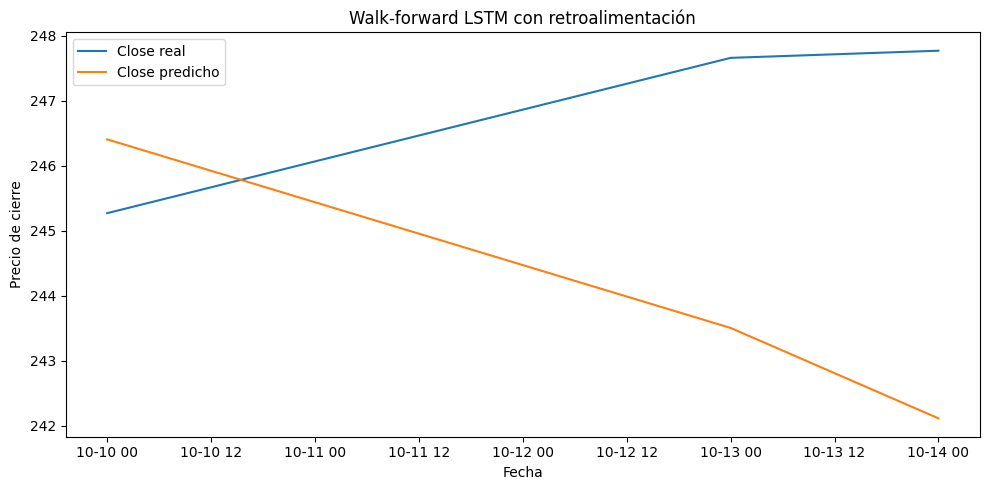

In [ ]:
# --------- ejecutar ---------
W = 50
day_start    = pd.Timestamp("2025-10-10")  # ajustá si querés
horizon_days = 3                           # cantidad de días hábiles a predecir
training_years = 2                         # años previos para entrenar y predecir cada día
df = prices.copy()

res_df = walk_forward_predict(df, 
                              day_start, 
                              horizon_days, 
                              W=W, 
                              torch_seed=0, 
                              training_years=training_years,
                              retroalimentacion=False, 
                              device=device)

# métricas y gráfico
if len(res_df) > 0:
    mae  = float(np.mean(np.abs(res_df["y_pred"] - res_df["y_true"])))
    rmse = float(np.sqrt(np.mean((res_df["y_pred"] - res_df["y_true"])**2)))
    print(f"Horizonte: {len(res_df)} días hábiles | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    plt.figure(figsize=(10,5))
    plt.plot(res_df.index, res_df["y_true"], label="Close real")
    plt.plot(res_df.index, res_df["y_pred"], label="Close predicho")
    plt.title("Walk-forward LSTM con retroalimentación")
    plt.xlabel("Fecha"); plt.ylabel("Precio de cierre")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No se generaron predicciones (¿hay suficiente historia previa de 2 años y columna 'Close'?))")